<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Fernando_Fortes_Granado/Pruning_GPT_J_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jul 20 20:18:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6

In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 5.1 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 596 kB 68.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 56.5 MB/s 
     |████████████████████████████████| 1.1 MB 60.2 MB/s 
     |████████████████████████████████| 140 kB 57.6 MB/s 
     |████████████████████████████████| 127 kB 63.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 65.7 MB/s 
     |████████████████████████████████| 144 kB 42.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import random
from transformers import AutoTokenizer, GPTNeoXForCausalLM
from transformers import GPTJForCausalLM, GPTNeoXTokenizerFast
from transformers import GPT2Tokenizer, GPT2Model

random.seed(10)

model = GPTJForCausalLM.from_pretrained(
    "EleutherAI/gpt-j-6B", revision="float16", torch_dtype=torch.float16, low_cpu_mem_usage=True
)

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

device = torch.device("cuda")
model.to(device)

model_cpu = GPTJForCausalLM.from_pretrained(
    "EleutherAI/gpt-j-6B", revision="float16", torch_dtype=torch.float16, low_cpu_mem_usage=True
)

Downloading:   0%|          | 0.00/836 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
from typing import *
from datasets import load_dataset
import numpy as np

class Dataset:
  def __init__(self, dataset, max_tokens):
    self.max_tokens = max_tokens
    self.dataset = dataset
    self.token_dataset = [
        (
            tokenizer(dataset[idx]["text"], return_tensors="pt"),
            "Positive" if dataset[idx]["label"] else "Negative",
        ) for idx in range(len(dataset))
    ]
    num_tokens = np.array([self.token_dataset[idx][0].input_ids.shape[1] for idx in range(len(dataset))])
    self.dataset_idx = np.argwhere(num_tokens <= max_tokens).reshape(-1)
  
  def __getitem__(self, idx):
    return self.token_dataset[int(self.dataset_idx[idx])]

  def get_raw_item(self, idx):
    item = self.dataset[int(self.dataset_idx[idx])]
    return item["text"], "Positive" if item["label"] else "Negative"

  def __len__(self):
    return len(self.dataset_idx)

  
class InferencePromptGen:
  def __init__(self, learning_examples: List[Tuple[str, str]], dataset: Dataset):
    self.dataset = dataset
    self.learning_examples = learning_examples
    self.fixed_text = self._get_fixed_text()

  def __getitem__(self, idx):
    return f"{self.fixed_text}\n\n{self._get_inference_text(idx)}", self.dataset[idx][1]

  def _get_fixed_text(self):
    instruction = "Instruction: Given a movie review, answer if the sentiment of the review is positive or negative."
    examples = "\n\n".join([f"""Example {i}:\nReview: {text}\nSentiment: {label}""" for i, (text, label) in enumerate(self.learning_examples)])
    return f"{instruction}\n\n{examples}"

  def _get_inference_text(self, idx):
    return f"Example {len(self.learning_examples)}:\nReview: {self.dataset.get_raw_item(idx)[0]}\nSentiment"


def predict(prompt, model, tokenizer):
  tokenized = tokenizer(prompt, return_tensors="pt")
  input_ids = tokenized.input_ids.to(device)
  attention_mask = tokenized.attention_mask.to(device)

  with torch.no_grad():
    gen_tokens = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=1,
        max_length=2048,
    )
  gen_text = tokenizer.batch_decode(gen_tokens)[0]
  return gen_text.split("\n")[len(prompt.split("\n")) - 1].split()[1]


imdb = load_dataset("imdb")
MAX_TOKENS = 300
NUM_INFERENCE_SAMPLES = 200
NUM_LEARNING_SAMPLES = 7

train_dataset = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=MAX_TOKENS,
)

test_dataset = Dataset(
    dataset=imdb["test"].shuffle(seed=42),
    max_tokens=MAX_TOKENS,
)

train_prompt_gen = InferencePromptGen(
    learning_examples=[train_dataset.get_raw_item(i) for i in range(NUM_LEARNING_SAMPLES)],
    dataset=train_dataset,
)

test_prompt_gen = InferencePromptGen(
    learning_examples=[train_dataset.get_raw_item(i) for i in range(NUM_LEARNING_SAMPLES)],
    dataset=test_dataset,
)

samples = list(range(NUM_INFERENCE_SAMPLES))
test_prompts = [test_prompt_gen[i][0] for i in samples]
test_labels = [test_prompt_gen[i][1] for i in samples]

samples = list(range(NUM_LEARNING_SAMPLES, NUM_LEARNING_SAMPLES + NUM_INFERENCE_SAMPLES))
train_prompts = [train_prompt_gen[i][0] for i in samples]
train_labels = [train_prompt_gen[i][1] for i in samples]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2174 > 2048). Running this sequence through the model will result in indexing errors


## **Balanceamento**


*   200 prompts de teste: 101 positivos, 99 negativos



In [ ]:
print(test_labels.count("Positive"))
print(test_labels.count("Negative"))

101
99


In [ ]:
import torch
def evaluate(model, tokenizer, prompts: List[str], labels: List[str]):
  num_correct_preds = 0
  for idx in range(len(prompts)):
    if ((idx % 10) == 0) and (idx != 0):
      print(f"Number of samples evaluated: {idx}, Number of correct preds: {num_correct_preds}, Accuracy: {num_correct_preds / idx}")
    output = predict(prompts[idx], model, tokenizer)
    print(labels[idx], output, labels[idx] == output)

    if labels[idx] == output:
      num_correct_preds += 1
    else:
      print(f"\n_____________________________\n\nPROMPT\n{prompts[idx]}\n\n_____________________________\n\nLABEL\n{labels[idx]}\nOUTPUT\n{output}\n\n_____________________________\n\n")
  return num_correct_preds / len(prompts)


def evaluate_perplexity(model, tokenizer, dataset: Dataset, num_samples):
  acc_loss = 0
  acc_tokens = 0
  all_idxs = list(range(len(dataset)))
  sampled_idxs = random.sample(all_idxs, num_samples)
  for samples_evaluated, idx in enumerate(sampled_idxs):
    if ((samples_evaluated % 1000) == 0) and (samples_evaluated != 0):
      print(f"Number of samples evaluated: {samples_evaluated}, Average perplexity: {torch.exp(torch.tensor(acc_loss / acc_tokens))}")

    input_ids = dataset[idx][0].input_ids.to(device)
    attention_mask = dataset[idx][0].attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = outputs.loss
    logits = outputs.logits
    acc_loss += loss.item() * input_ids.shape[1]  # soma do loss para todos os tokens da frase
    acc_tokens += input_ids.shape[1]  # numero de tokens

  return torch.exp(torch.tensor(acc_loss / acc_tokens))

## **Cálculo da Perplexidade:**


*   Filtro de amostras com até 2048 tokens
*   20 amostras (5100 tokens). 13 segundos por avaliação
*   **Baseline de treino: 18.1260**
*   **Baseline de teste: 18.1838**



In [ ]:
train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)
perplexity = evaluate_perplexity(model, tokenizer, train_dataset_lim_2048, len(train_dataset_lim_2048))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow


Number of samples evaluated: 1000, Average perplexity: 18.34537124633789
Number of samples evaluated: 2000, Average perplexity: 18.14519500732422
Number of samples evaluated: 3000, Average perplexity: 18.19786834716797
Number of samples evaluated: 4000, Average perplexity: 18.21194839477539
Number of samples evaluated: 5000, Average perplexity: 18.187732696533203
Number of samples evaluated: 6000, Average perplexity: 18.179515838623047
Number of samples evaluated: 7000, Average perplexity: 18.147804260253906
Number of samples evaluated: 8000, Average perplexity: 18.179256439208984
Number of samples evaluated: 9000, Average perplexity: 18.17890167236328
Number of samples evaluated: 10000, Average perplexity: 18.15471076965332
Number of samples evaluated: 11000, Average perplexity: 18.165054321289062
Number of samples evaluated: 12000, Average perplexity: 18.145713806152344
Number of samples evaluated: 13000, Average perplexity: 18.118682861328125
Number of samples evaluated: 14000, Aver

In [ ]:
perplexity

tensor(18.1260)

In [ ]:
test_dataset_lim_2048 = Dataset(
    dataset=imdb["test"].shuffle(seed=42),
    max_tokens=2048,
)
perplexity = evaluate_perplexity(model, tokenizer, test_dataset_lim_2048, len(test_dataset_lim_2048))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow


Number of samples evaluated: 1000, Average perplexity: 17.848831176757812
Number of samples evaluated: 2000, Average perplexity: 17.872148513793945
Number of samples evaluated: 3000, Average perplexity: 18.00782585144043
Number of samples evaluated: 4000, Average perplexity: 18.090866088867188
Number of samples evaluated: 5000, Average perplexity: 18.17220115661621
Number of samples evaluated: 6000, Average perplexity: 18.1843318939209
Number of samples evaluated: 7000, Average perplexity: 18.144287109375
Number of samples evaluated: 8000, Average perplexity: 18.15644645690918
Number of samples evaluated: 9000, Average perplexity: 18.147777557373047
Number of samples evaluated: 10000, Average perplexity: 18.136600494384766
Number of samples evaluated: 11000, Average perplexity: 18.140609741210938
Number of samples evaluated: 12000, Average perplexity: 18.1279296875
Number of samples evaluated: 13000, Average perplexity: 18.113819122314453
Number of samples evaluated: 14000, Average per

In [ ]:
perplexity

tensor(18.1838)

## **Precisão Few-Shot:**


*   200 prompts
*   Filtro de amostras com até 300 tokens
*   **Baseline de treino: 94%** (nas 100 primeiras amostras, foi 96%)
*   **Baseline de teste: 94,5%** (nas 100 primeiras amostras, foi 95%)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
accuracy = evaluate(model, tokenizer, train_prompts, train_labels)

Positive Positive True
Negative Negative True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Positive Negative False

_____________________________

PROMPT
Instruction: Given a movie review, answer if the sentiment of the review is positive or negative.

Example 0:
Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just en

In [ ]:
accuracy

0.94

In [ ]:
accuracy = evaluate(model, tokenizer, test_prompts, test_labels)

Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Number of samples evaluated: 20, Number of correct preds: 20, Accuracy: 1.0
Negative Negative True
Positive Positive True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Number of samples evaluated: 30, Number of correct preds: 30, Accuracy: 1.0
Negative Negative True
Negative Negative True
Negative Negative True
Negative Nega

In [ ]:
accuracy

0.945

## **Testes de Pruning de cabeças de atenção:**


*   Pruning de todas as cabeças de uma camada não necessariamente destroem o desempenho pois as skip connections permitem o fluxo de informação através delas 
*   Pruning de poucas cabeças devem interferir pouco no resultado
*   Pruning de muitas cabeças aleatoriamente devem progressivamente derrubar o desempenho

Implementação: o GPT-J possui camadas com 16 cabeças de atenção, cada uma com dimensão 256. Para realizar o pruning, iremos zerar um bloco de 256 elementos do vetor v_proj, fazendo com que o vetor de valores de uma cabeça seja sempre 0, de forma que sua saída será 0.

Adicionar camada de pruning pode fazer o modelo ocupar mais memória durante o desenvolvimento.

In [ ]:
v_proj_layers = []
for name, param in model.named_parameters():
    if "v_proj" in name:
        v_proj_layers.append((name, param))

NUM_LAYERS = len(v_proj_layers)
NUM_HEADS = 16
HEAD_DIM = 256
MODEL_DIM = NUM_HEADS * HEAD_DIM
TOTAL_NUM_HEADS = NUM_LAYERS * NUM_HEADS

In [ ]:
# Visualizando os pesos de uma v_proj de uma cabeça de uma camada
layer = 0
head = 0
model.state_dict()[v_proj_layers[layer][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,head,:]  # essa view foi obtida do codigo fonte do GPT-j

tensor([[ 0.0047, -0.0033, -0.0013,  ...,  0.0275,  0.0188,  0.0024],
        [-0.0052, -0.0143, -0.0018,  ...,  0.0131, -0.0031,  0.0146],
        [ 0.0203,  0.0271,  0.0326,  ..., -0.0054, -0.0129, -0.0244],
        ...,
        [ 0.0131, -0.0034,  0.0187,  ...,  0.0260, -0.0007,  0.0075],
        [-0.0081, -0.0316,  0.0125,  ...,  0.0189,  0.0147,  0.0095],
        [ 0.0006,  0.0200,  0.0051,  ...,  0.0244, -0.0071,  0.0047]],
       device='cuda:0', dtype=torch.float16)

Em uma avaliação com apenas 100 amostras, não nota-se desempenho ao realizar o prune com 1 cabeça de uma camada. A **perplexidade foi de 17,6** contra um baseline de **18,13**

In [ ]:
# Prune de uma cabeça de uma camada
model.state_dict()[v_proj_layers[layer][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,head,:] = 0

In [ ]:
import torch
torch.cuda.empty_cache()
evaluate_perplexity(model, tokenizer, train_dataset_lim_2048, num_samples=100)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow


tensor(17.6384)

Em uma avaliação com apenas 100 amostras, o prune de uma camada inteira (camada 0) levou a queda significativa de desempenho. A **perplexidade foi de 30,1** contra um baseline de **18,13**

In [ ]:
model.state_dict()[v_proj_layers[0][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,:,:] = 0
evaluate_perplexity(model, tokenizer, train_dataset_lim_2048, num_samples=100)

tensor(30.0607)

O prune de mais duas camadas inteiras (camadas 1 e 2) levou a perplexidade a **152,8**

In [ ]:
model.state_dict()[v_proj_layers[1][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,:,:] = 0
model.state_dict()[v_proj_layers[2][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,:,:] = 0
evaluate_perplexity(model, tokenizer, train_dataset_lim_2048, num_samples=100)

tensor(152.7537)

Com o prune de 3 camadas, o desempenho Few-shot no teste nas 20 primeiras amostras caiu de **100%** para **0%**

In [ ]:
evaluate(model, tokenizer, test_prompts[:20], test_labels[:20])

Positive "I'm False

_____________________________

PROMPT
Instruction: Given a movie review, answer if the sentiment of the review is positive or negative.

Example 0:
Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Sentiment: Positive

Example 1:
Review: This movie is a great. T

0.0

In [ ]:
from contextlib import contextmanager

# IDEIA: TER UM MODEL NA CPU E UM NA GPT. PARA RESTAURAR O MODEL, PEGAR O DA CPU E MANDAR TO_DEVICE.
@contextmanager
def prune(model, model_cpu, mask):
    v_proj_layers = []
    for name, param in model.named_parameters():
        if "v_proj" in name:
            v_proj_layers.append((name, param))

    for layer in range(mask.shape[0]):
        for head in range(mask.shape[1]):
            if mask[layer][head]:
                model.state_dict()[v_proj_layers[layer][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,head,:] = 0
    try:
        yield model
    finally:
        for layer in range(mask.shape[0]):
            for head in range(mask.shape[1]):
                if mask[layer][head]:
                    model.state_dict()[v_proj_layers[layer][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,head,:] = (
                        model_cpu.state_dict()[v_proj_layers[layer][0]].view(torch.Size([MODEL_DIM, NUM_HEADS, HEAD_DIM]))[:,head,:]
                    )

In [ ]:
train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)

masks = [torch.rand(NUM_LAYERS, NUM_HEADS) < prob for prob in torch.linspace(0, 1, steps=21)]
list_perc_pruned_heads = []
list_perplexities = []
for mask in masks:
    perc_pruned_heads = mask.sum().item() / TOTAL_NUM_HEADS
    list_perc_pruned_heads.append(perc_pruned_heads)

    with prune(model, model_cpu, mask) as pruned_model:
        list_perplexities.append(evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=1000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow


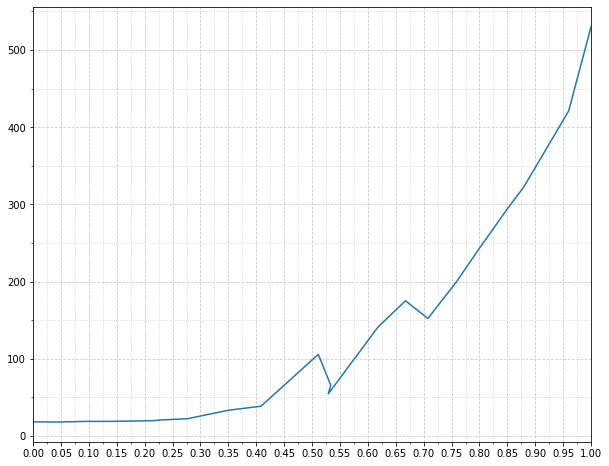

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(list_perc_pruned_heads, list_perplexities)

ax.set_xlim(0, 1)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(100))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.show()

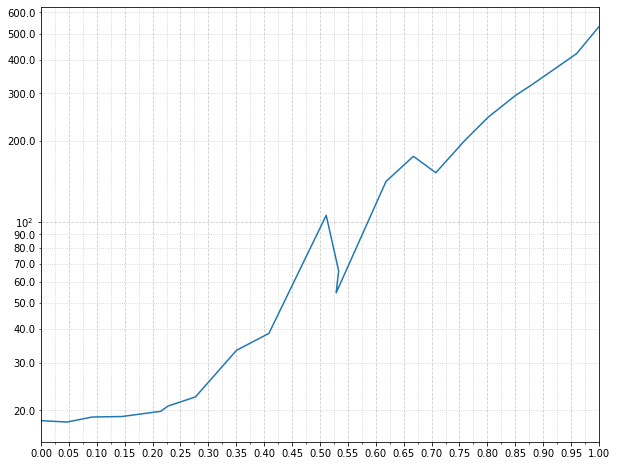

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(list_perc_pruned_heads, list_perplexities)

ax.set_xlim(0, 1)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(100))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.set_yscale('log')

ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

plt.show()

Mesmo com prune de 100% das cabeças de atenção, a perplexidade não foi para 50k (são 50k tokens). Acredita-se que isso é porque (1) as skip-connections ainda permitem o fluxo de alguma informação da entrada para a saída e (2) a rede pode estar gerando como saída tokens de alta frequência. 

## **Prune aleatório**

Com um prune aleatório de **21%** das cabeças de atenção, obteve-se perplexidade de **20,5** em 2000 amostras de treino. O baseline era **18,13**.

O desempenho few-shot em 200 amostras de teste foi de **91,5%**, contra um baseline de **94,5%**.

In [ ]:
train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)

mask = torch.rand(NUM_LAYERS, NUM_HEADS) < 0.2
perc_pruned_heads = mask.sum().item() / TOTAL_NUM_HEADS
with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=2000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow


Number of samples evaluated: 1000, Average perplexity: 20.634096145629883
tensor(20.4929)


In [ ]:
print(perc_pruned_heads)

0.20982142857142858


In [ ]:
test_dataset_lim_2048 = Dataset(
    dataset=imdb["test"].shuffle(seed=42),
    max_tokens=2048,
)

mask = torch.rand(NUM_LAYERS, NUM_HEADS) < 0.2
perc_pruned_heads = mask.sum().item() / TOTAL_NUM_HEADS
with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate_perplexity(pruned_model, tokenizer, test_dataset_lim_2048, num_samples=2000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow


Number of samples evaluated: 1000, Average perplexity: 19.5308895111084
tensor(19.4643)


In [ ]:
with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate(pruned_model, tokenizer, test_prompts, test_labels))

Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Number of samples evaluated: 20, Number of correct preds: 20, Accuracy: 1.0
Negative Negative True
Positive Positive True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Number of samples evaluated: 30, Number of correct preds: 30, Accuracy: 1.0
Negative Negative True
Negative Negative True
Negative Negative True
Negative Nega

In [ ]:
with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate(pruned_model, tokenizer, train_prompts, train_labels))

Positive Positive True
Negative Negative True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Positive Negative False

_____________________________

PROMPT
Instruction: Given a movie review, answer if the sentiment of the review is positive or negative.

Example 0:
Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weird

In [ ]:
# TODO: Executar os graficos de prune aleatorio com avaliacao com mais de 10 amostras (talvez 100)
# TODO: ver o commit anterior e copiar o lugar certo de limpar o cache. Estava dando menos erro.
# Obter baseline/grafico para pruning aleatorio
# obter todos os baselines
# TODO: testar prune de pesos das camadas densas por magnitude, pois possuem 4,5B dos 6B de parâmetros

## **Global Pruning**

In [ ]:
@contextmanager
def prune_head_idx_from_mask(mask, idx):
   mask[:, idx] = 1
   try:
      yield mask
   finally:
      mask[:, idx] = 0

train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)

test_dataset_lim_2048 = Dataset(
    dataset=imdb["test"].shuffle(seed=42),
    max_tokens=2048,
)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow


In [ ]:
mask = torch.zeros(NUM_LAYERS, NUM_HEADS)

all_heads = set(list(range(NUM_HEADS)))
pruned_heads = set()
used_heads = all_heads - pruned_heads

min_perplexities = []
eval_perplexities = []
heads = []

while(len(used_heads) > 0):
    min_perplexity = 1_000_000
    min_perplexity_head = None
    for head_idx in used_heads:
        with prune_head_idx_from_mask(mask, head_idx) as new_mask:
            with prune(model, model_cpu, new_mask) as pruned_model:
                perplexity = evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=500)
                if perplexity < min_perplexity:
                    min_perplexity = perplexity
                    min_perplexity_head = head_idx
    
    mask[:, min_perplexity_head] = 1
    pruned_heads = pruned_heads.union([min_perplexity_head])
    used_heads = all_heads - pruned_heads
    min_perplexities.append(min_perplexity)
    heads.append(min_perplexity_head)
    with prune(model, model_cpu, mask) as pruned_model:
        eval_perplexities.append(evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=2000))
    print(min_perplexity_head, min_perplexity, eval_perplexities)

Number of samples evaluated: 1000, Average perplexity: 18.031967163085938
8 tensor(17.2495) [tensor(18.0696)]
Number of samples evaluated: 1000, Average perplexity: 18.693527221679688
6 tensor(18.2578) [tensor(18.0696), tensor(18.6888)]
Number of samples evaluated: 1000, Average perplexity: 19.663564682006836
7 tensor(18.5683) [tensor(18.0696), tensor(18.6888), tensor(19.5360)]
Number of samples evaluated: 1000, Average perplexity: 20.432287216186523
9 tensor(20.2389) [tensor(18.0696), tensor(18.6888), tensor(19.5360), tensor(20.3111)]
Number of samples evaluated: 1000, Average perplexity: 22.17514991760254
13 tensor(21.7738) [tensor(18.0696), tensor(18.6888), tensor(19.5360), tensor(20.3111), tensor(22.1741)]
Number of samples evaluated: 1000, Average perplexity: 25.797725677490234
14 tensor(25.1052) [tensor(18.0696), tensor(18.6888), tensor(19.5360), tensor(20.3111), tensor(22.1741), tensor(25.6691)]
Number of samples evaluated: 1000, Average perplexity: 34.34476089477539
2 tensor(33

In [ ]:
# [8, 6, 7, 9, 13, 14, 2, 5, 3, 12, 11, 0, 15, 4, 10, 1]
# [tensor(18.0696), tensor(18.6888), tensor(19.5360), tensor(20.3111), tensor(22.1741), tensor(25.6691), tensor(34.0141), tensor(49.1004), tensor(81.6989), tensor(123.9741), tensor(156.6765), tensor(200.2352), tensor(252.0539), tensor(319.1900), tensor(417.9189), tensor(526.9009)]

In [ ]:
list_perc_pruned_heads = [(x + 1)/16 for x in range(16)]
list_perplexities = [18.0696, 18.6888, 19.5360, 20.3111, 22.1741, 25.6691, 34.0141, 49.1004, 81.6989, 123.9741, 156.6765,200.2352,252.0539,319.1900,417.9189,526.9009]

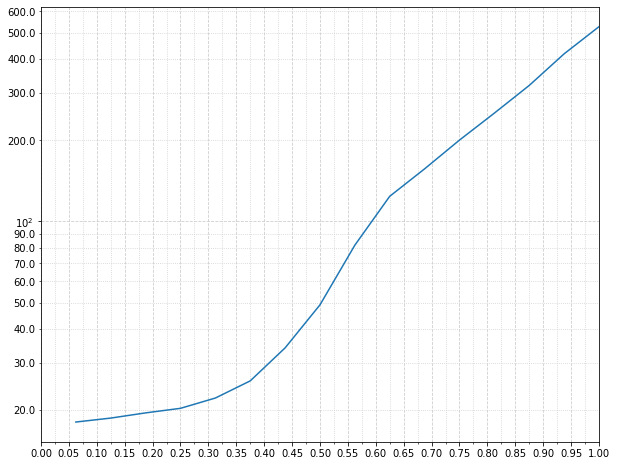

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(list_perc_pruned_heads, list_perplexities)

ax.set_xlim(0, 1)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(100))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.set_yscale('log')

ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

plt.show()

In [ ]:
mask = torch.zeros(NUM_LAYERS, NUM_HEADS)
mask[:, 8] = 1
mask[:, 6] = 1
mask[:, 7] = 1
mask[:, 9] = 1
with prune(model, model_cpu, mask) as pruned_model:
    print("Train Perplexity with 25% head pruning using Global Pruning", evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=2000))
    print("Test Perplexity with 25% head pruning using Global Pruning", evaluate_perplexity(pruned_model, tokenizer, test_dataset_lim_2048, num_samples=2000))

Number of samples evaluated: 1000, Average perplexity: 20.577402114868164
Train Perplexity with 25% head pruning using Global Pruning tensor(20.4179)
Number of samples evaluated: 1000, Average perplexity: 20.561548233032227
Test Perplexity with 25% head pruning using Global Pruning tensor(20.5458)


In [ ]:
with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate(pruned_model, tokenizer, test_prompts, test_labels))

Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Number of samples evaluated: 20, Number of correct preds: 20, Accuracy: 1.0
Negative Negative True
Positive Positive True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Number of samples evaluated: 30, Number of correct preds: 30, Accuracy: 1.0
Negative Negative True
Negative Negative True
Negative Negative True
Negative Nega

In [ ]:
mask = torch.zeros(NUM_LAYERS, NUM_HEADS)
mask[:, 8] = 1
mask[:, 6] = 1
mask[:, 7] = 1
with prune(model, model_cpu, mask) as pruned_model:
    print("Train Perplexity with 25% head pruning using Global Pruning", evaluate_perplexity(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=2000))
    print("Test Perplexity with 25% head pruning using Global Pruning", evaluate_perplexity(pruned_model, tokenizer, test_dataset_lim_2048, num_samples=2000))

with prune(model, model_cpu, mask) as pruned_model:
    print(evaluate(pruned_model, tokenizer, test_prompts, test_labels))

Number of samples evaluated: 1000, Average perplexity: 19.300485610961914
Train Perplexity with 25% head pruning using Global Pruning tensor(19.3764)
Number of samples evaluated: 1000, Average perplexity: 19.330455780029297
Test Perplexity with 25% head pruning using Global Pruning tensor(19.2359)
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Negative Negative True
Positive Positive True
Positive Positive True
Number of samples evaluated: 10, Number of correct preds: 10, Accuracy: 1.0
Negative Negative True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Positive Positive True
Negative Negative True
Positive Positive True
Negative Negative True
Positive Positive True
Number of samples evaluated: 20, Number of correct preds: 20, Accuracy: 1.0
Negative Negative True
Positive Positive True
Positive Positive True
Positive Positive Tr

## **Pruning com Busca A***

In [ ]:
def evaluate_perplexity_deterministic(model, tokenizer, dataset: Dataset, num_samples):
  acc_loss = 0
  acc_tokens = 0
  all_idxs = list(range(len(dataset)))
  random.seed(10)  # Faz a selecao de amostras ser deterministica
  sampled_idxs = random.sample(all_idxs, num_samples)
  for samples_evaluated, idx in enumerate(sampled_idxs):
    if ((samples_evaluated % 1000) == 0) and (samples_evaluated != 0):
      print(f"Number of samples evaluated: {samples_evaluated}, Average perplexity: {torch.exp(torch.tensor(acc_loss / acc_tokens))}")

    input_ids = dataset[idx][0].input_ids.to(device)
    attention_mask = dataset[idx][0].attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = outputs.loss
    logits = outputs.logits
    acc_loss += loss.item() * input_ids.shape[1]  # soma do loss para todos os tokens da frase
    acc_tokens += input_ids.shape[1]  # numero de tokens

  return torch.exp(torch.tensor(acc_loss / acc_tokens))

def calculate_P(model, L, eliminated, dataset):
    P = 1_000_000 * torch.ones(NUM_LAYERS, NUM_HEADS)
    eliminated_or_pruned = torch.logical_or(L, eliminated)
    for layer in range(L.shape[0]):
        for head in range(L.shape[1]):
            if eliminated_or_pruned[layer][head] == 0:
                L[layer][head] = 1
                with prune(model, model_cpu, L) as pruned_model:
                    P[layer][head] = evaluate_perplexity_deterministic(pruned_model, tokenizer, dataset, num_samples=40)
                L[layer][head] = 0
    return P

train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)

In [ ]:
baseline = evaluate_perplexity_deterministic(model, tokenizer, train_dataset_lim_2048, num_samples=40)
baseline

tensor(20.0826)

In [ ]:
budget = 1
B = budget
# S = TOTAL_NUM_HEADS
# L = torch.zeros(NUM_LAYERS, NUM_HEADS)
# eliminated = torch.zeros(NUM_LAYERS, NUM_HEADS)
while B > 0 and S > 0:
    P = calculate_P(model, L, eliminated, train_dataset_lim_2048)
    print("P", P)
    C = P - baseline
    print("C", C)
    C_arg_sort = torch.argsort(C.view(-1))
    X = C_arg_sort[0]  # Argmin da matriz planificada
    C_x = C[X // NUM_HEADS][X % NUM_HEADS]
    if C_x < 0:
        C_x = 0
    if C_x < B:
        L[X // NUM_HEADS][X % NUM_HEADS] = 1
        print("L", L)
        B = B - C_x
        S -= 1
        if S > 0:
            T = 0
            flag_elimitate_remaining = False
            for head in C_arg_sort:  # head é o indice flat
                if flag_elimitate_remaining == False:
                  E_y = C[head // NUM_HEADS][head % NUM_HEADS]  # MULTIPLICAR POR 0,95 OU 0,9 PARA ELIMINAR MENOS E TRATAR A VARIANCIA
                  I_y = E_y - C_x
                  if T + I_y <= B:
                      T += I_y
                  else:
                      eliminated[head // NUM_HEADS][head % NUM_HEADS] = 1
                      flag_elimitate_remaining = True
                else:
                    eliminated[head // NUM_HEADS][head % NUM_HEADS] = 1
            print("eliminated", eliminated)
            S = TOTAL_NUM_HEADS - torch.sum(torch.logical_or(eliminated, L))
              
    else:
        break

P tensor([[1.0000e+06, 1.9979e+01, 1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06,
         1.9987e+01, 1.0000e+06, 1.9978e+01, 1.9995e+01, 1.0000e+06, 1.0000e+06,
         1.0000e+06, 1.9985e+01, 1.0000e+06, 1.0000e+06],
        [1.9989e+01, 1.9977e+01, 1.0000e+06, 1.0000e+06, 1.9991e+01, 1.9982e+01,
         1.9985e+01, 1.9995e+01, 1.0000e+06, 1.0000e+06, 1.9986e+01, 1.0000e+06,
         1.9992e+01, 2.0016e+01, 1.0000e+06, 1.9990e+01],
        [1.0000e+06, 1.9980e+01, 1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06,
         1.0000e+06, 1.0000e+06, 1.9982e+01, 1.9987e+01, 2.0001e+01, 1.0000e+06,
         1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06],
        [1.0000e+06, 1.9994e+01, 1.0000e+06, 1.9978e+01, 1.0000e+06, 1.9980e+01,
         1.9976e+01, 1.9989e+01, 1.9985e+01, 1.9977e+01, 1.9982e+01, 1.0000e+06,
         1.9986e+01, 1.0000e+06, 1.9979e+01, 1.9982e+01],
        [1.0000e+06, 1.9985e+01, 1.9984e+01, 1.9987e+01, 1.0000e+06, 1.9984e+01,
         1.9984e+01, 1.9979e+01, 1.00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: __floordiv__ is deprecated, and its b

P tensor([[1.0000e+06, 1.9983e+01, 1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06,
         1.9987e+01, 1.0000e+06, 1.9981e+01, 1.9995e+01, 1.0000e+06, 1.0000e+06,
         1.0000e+06, 1.9987e+01, 1.0000e+06, 1.0000e+06],
        [1.9992e+01, 1.9982e+01, 1.0000e+06, 1.0000e+06, 1.9987e+01, 1.9991e+01,
         1.9993e+01, 1.9999e+01, 1.0000e+06, 1.0000e+06, 1.9981e+01, 1.0000e+06,
         1.9999e+01, 2.0017e+01, 1.0000e+06, 1.9992e+01],
        [1.0000e+06, 1.9981e+01, 1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06,
         1.0000e+06, 1.0000e+06, 1.9982e+01, 1.9986e+01, 2.0003e+01, 1.0000e+06,
         1.0000e+06, 1.0000e+06, 1.0000e+06, 1.0000e+06],
        [1.0000e+06, 1.9991e+01, 1.0000e+06, 1.9988e+01, 1.0000e+06, 1.9981e+01,
         1.9985e+01, 1.9991e+01, 1.9983e+01, 1.9982e+01, 1.9984e+01, 1.0000e+06,
         1.9987e+01, 1.0000e+06, 1.9985e+01, 1.9979e+01],
        [1.0000e+06, 1.9985e+01, 1.9987e+01, 1.9990e+01, 1.0000e+06, 1.9990e+01,
         1.9979e+01, 1.9982e+01, 1.00

## Pruning não estruturado

In [ ]:
import torch.nn.utils.prune as prune_2
amount = 0.3
num_layers = 5
# Não foi possível realizar um prune.global_unstructured com todas as camadas por conta de estouro de memória.
# A solução foi aplicar de 10 em 10 camadas. É um meio termo entre global_unstructured e local_unstructured.
for offset in [0, 5, 10, 15, 20]:
  for layer in range(num_layers):
    # Transforma os pesos em matriz contigua e float32, necessário para executar a função torch.nn.utils.prune.global_unstructured
    model.transformer.h[layer + offset].mlp.fc_in.weight = torch.nn.Parameter(model.transformer.h[layer + offset].mlp.fc_in.weight.contiguous().float())
    model.transformer.h[layer + offset].mlp.fc_out.weight = torch.nn.Parameter(model.transformer.h[layer + offset].mlp.fc_out.weight.contiguous().float())


  # Define as camadas consideradas ao calcular os pesos de menor magnitude (10 camadas por vez)
  parameters_to_prune = []
  for layer in range(num_layers):
    parameters_to_prune.append((model.transformer.h[layer + offset].mlp.fc_in, 'weight'))
    parameters_to_prune.append((model.transformer.h[layer + offset].mlp.fc_out, 'weight'))
  parameters_to_prune = tuple(parameters_to_prune)


  # Adiciona a máscara de pruning nas 10 camadas. Para realizar o pruning aleatório, troucou-se por torch.nn.utils.prune.random_unstructured
  torch.nn.utils.prune.global_unstructured(
      parameters_to_prune,
      pruning_method=torch.nn.utils.prune.L1Unstructured,
      amount=amount,
  )

  # Remove a máscara de pruning, tornando o pruning irreversível e liberando memória
  for layer in range(num_layers):
    torch.nn.utils.prune.remove(model.transformer.h[layer + offset].mlp.fc_in, 'weight')
    torch.nn.utils.prune.remove(model.transformer.h[layer + offset].mlp.fc_out, 'weight')

  # Transforma os pesos de volta para float16, economizando memoria
  for layer in range(num_layers):
    model.transformer.h[layer + offset].mlp.fc_in.weight = torch.nn.Parameter(model.transformer.h[layer + offset].mlp.fc_in.weight.half())
    model.transformer.h[layer + offset].mlp.fc_out.weight = torch.nn.Parameter(model.transformer.h[layer + offset].mlp.fc_out.weight.half())

model.to(device)

In [ ]:
train_dataset_lim_2048 = Dataset(
    dataset=imdb["train"].shuffle(seed=42),
    max_tokens=2048,
)
print(f"Train perplexity: {evaluate_perplexity(model, tokenizer, train_dataset_lim_2048, 1000)}")
print(f"Train accuracy: {evaluate(model, tokenizer, train_prompts, train_labels)}")

10%: 18.3523, 94,5%

20%: 18,6543 de perplexidade em 1000 amostras e 93,5% de acuracia

30% -> 19.6260 e 92,5%

35% -> 21.4182 e 88,5%

40% -> 36.9943 e 60,5%

Aleatório de 20%: 114.2721 e 49%

## Testes

In [ ]:
L = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

eliminated = torch.tensor([[1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.]])



S = TOTAL_NUM_HEADS - torch.sum(torch.logical_or(eliminated, L))

print(torch.sum(torch.logical_or(eliminated, L)))
print(torch.sum(L))
print(S)

tensor(157)
tensor(38.)
tensor(291)


In [ ]:
with prune(model, model_cpu, L) as pruned_model:
    print(evaluate_perplexity_deterministic(pruned_model, tokenizer, train_dataset_lim_2048, num_samples=40))

tensor(19.9460)


In [ ]:
test_dataset_lim_2048 = Dataset(
    dataset=imdb["test"].shuffle(seed=42),
    max_tokens=2048,
)
print(evaluate_perplexity_deterministic(model, tokenizer, test_dataset_lim_2048, num_samples=1000))

tensor(18.1552)


In [ ]:
with prune(model, model_cpu, L) as pruned_model:
    print(evaluate_perplexity_deterministic(pruned_model, tokenizer, test_dataset_lim_2048, num_samples=1000))

tensor(18.3444)


In [ ]:
38/446

0.08520179372197309